In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from astroNN.nn.layers import MCDropout
import numpy as np
import matplotlib.pyplot as plt

2022-05-17 18:01:10.808066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:01:10.808143: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df=pd.read_csv('data/jla.csv')
z = df.values[:,0]
y = df.values[:,1:]
# scaleryerr = MinMaxScaler(feature_range=(0,1))
# # scaleryerr = StandardScaler()
# scaleryerr.fit(y[:,1].reshape(-1, 1))
# y[:,1] = (scaleryerr.transform(y[:,1].reshape(-1, 1))).reshape(1,-1)
y[:,1] = np.log10(y[:,1])

In [3]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [4]:
# r = scalerz.transform(z.reshape(-1, 1))
# predh = model.predict(r)

In [5]:
ffnn_do = tf.keras.models.load_model('models/FFNN_MCDO4is.h5', custom_objects={'MCDropout': MCDropout})

2022-05-17 18:01:13.671080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 18:01:13.671721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:01:13.671843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-17 18:01:13.671944: W tensorflow/stream_ex

## Now only at the new redshifts (existing in Pantheon but not in JLA and < z_jlamax)

In [6]:
znews = pd.read_csv('data/not_in _jla.csv', usecols=[0])
md_pantheon = pd.read_csv('data/not_in _jla.csv', usecols=[1])
x_pantheon = pd.read_csv('data/not_in _jla.csv', usecols=[0, 1])
err_pantheon = pd.read_csv('data/not_in _jla.csv', usecols=[3])

In [7]:
test_batch_size = len(znews)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))

for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(scalerz.transform(znews.values))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
# errpred = scaleryerr.inverse_transform(prediction_mc_dropout[:,1].reshape(-1,1))
errpred = np.exp(prediction_mc_dropout[:,1])
ln = len(errpred)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ errpred.reshape(ln,)**2)

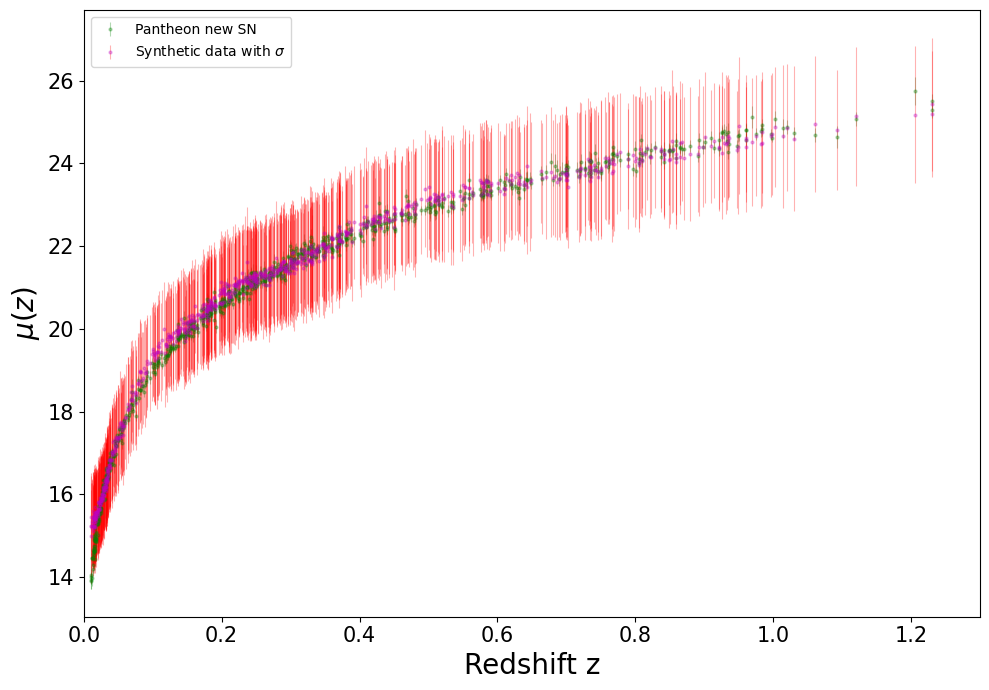

In [8]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
errpred = np.exp(prediction_mc_dropout[:,1])
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ errpred**2)


plt.errorbar(znews.values, md_pantheon.values, yerr=err_pantheon.values[:,0], markersize=2, fmt='o', 
             ecolor='g', capthick=2, elinewidth=0.8, alpha=0.3, c='g',
             label='Pantheon new SN')

plt.errorbar(znews.values, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [9]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockmuz_ffnn_mcdo = np.concatenate((znews.values, prediction_mc_dropout[:,0].reshape(-1,1)), axis=1)


np.savetxt("sn_news.dat",mockmuz_ffnn_mcdo, delimiter=" ")
ncov = len(znews)
neuralcov = np.diag(errpred.reshape(ncov,))

np.savetxt("sn_news_cov.dat", neuralcov , header="#{}x{}".format(ncov, ncov), delimiter=' ' )

In [10]:
np.shape(neuralcov)

(895, 895)

In [14]:
np.min(neuralcov), np.max(neuralcov)

(0.0, 0.43434369922254046)

In [15]:
errnot = err_pantheon.values.reshape(l,)

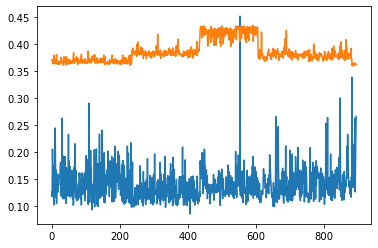

In [16]:
plt.plot(err_pantheon)
plt.plot(errpred)

In [17]:
len(np.diag(neuralcov)), len(errnot)

(895, 895)